In [1]:
#download of a youtube video
import yt_dlp

# Set the URL of the YouTube video
url = 'https://www.youtube.com/watch?v=WDIpL0pjun0'

# Define download options (download the best quality video)
ydl_opts = {
    'format': 'best',  # Download the best quality available
    'outtmpl': 'pushup_perfect.mp4',  # Name of the output file
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

print("Video downloaded successfully.")

[youtube] Extracting URL: https://www.youtube.com/watch?v=WDIpL0pjun0
[youtube] WDIpL0pjun0: Downloading webpage
[youtube] WDIpL0pjun0: Downloading tv client config
[youtube] WDIpL0pjun0: Downloading player 20830619
[youtube] WDIpL0pjun0: Downloading tv player API JSON
[youtube] WDIpL0pjun0: Downloading ios player API JSON
[youtube] WDIpL0pjun0: Downloading m3u8 information
[info] WDIpL0pjun0: Downloading 1 format(s): 18
[download] Destination: pushup_perfect.mp4
[download] 100% of  487.24KiB in 00:00:00 at 1.10MiB/s   
Video downloaded successfully.


In [1]:
#laden model en bekijken keypoints (17 stuks volgens coco dataset) van 1 image
import cv2
import time
import torch
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleHRNet(32, 17, "./pose_hrnet_w32_256x192.pth", device=device, multiperson=False)
image = cv2.imread("demo.jpg", cv2.IMREAD_COLOR)
#predicts calls methods for preprocessing (resize, normalize, crop and color conversion)
joints = model.predict(image)

print(joints.shape)
print(joints)

C:\Users\Gordts-De Laender\Desktop\Papa\OU\DNE\simple-HRNet\SimpleHRNet.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_lo

device: 'cpu'
(1, 17, 3)
[[[ 79.6875     364.44446      0.9930577 ]
  [ 75.260414   373.33334      0.9357035 ]
  [ 75.260414   355.55554      0.9478723 ]
  [ 75.260414   391.1111       0.92953   ]
  [ 79.6875     355.55554      0.8547665 ]
  [106.25       400.           0.84298724]
  [123.958336   364.44446      0.7481577 ]
  [146.09375    435.55554      0.83801794]
  [159.375      346.66666      0.8611997 ]
  [163.80208    444.44446      0.8744751 ]
  [177.08333    302.22223      0.9267238 ]
  [203.64583    426.66666      0.73707324]
  [208.07292    408.8889       0.7458898 ]
  [287.7604     435.55554      0.8665572 ]
  [274.47916    373.33334      0.90258133]
  [367.4479     471.1111       0.79892826]
  [345.3125     400.           0.7697193 ]]]


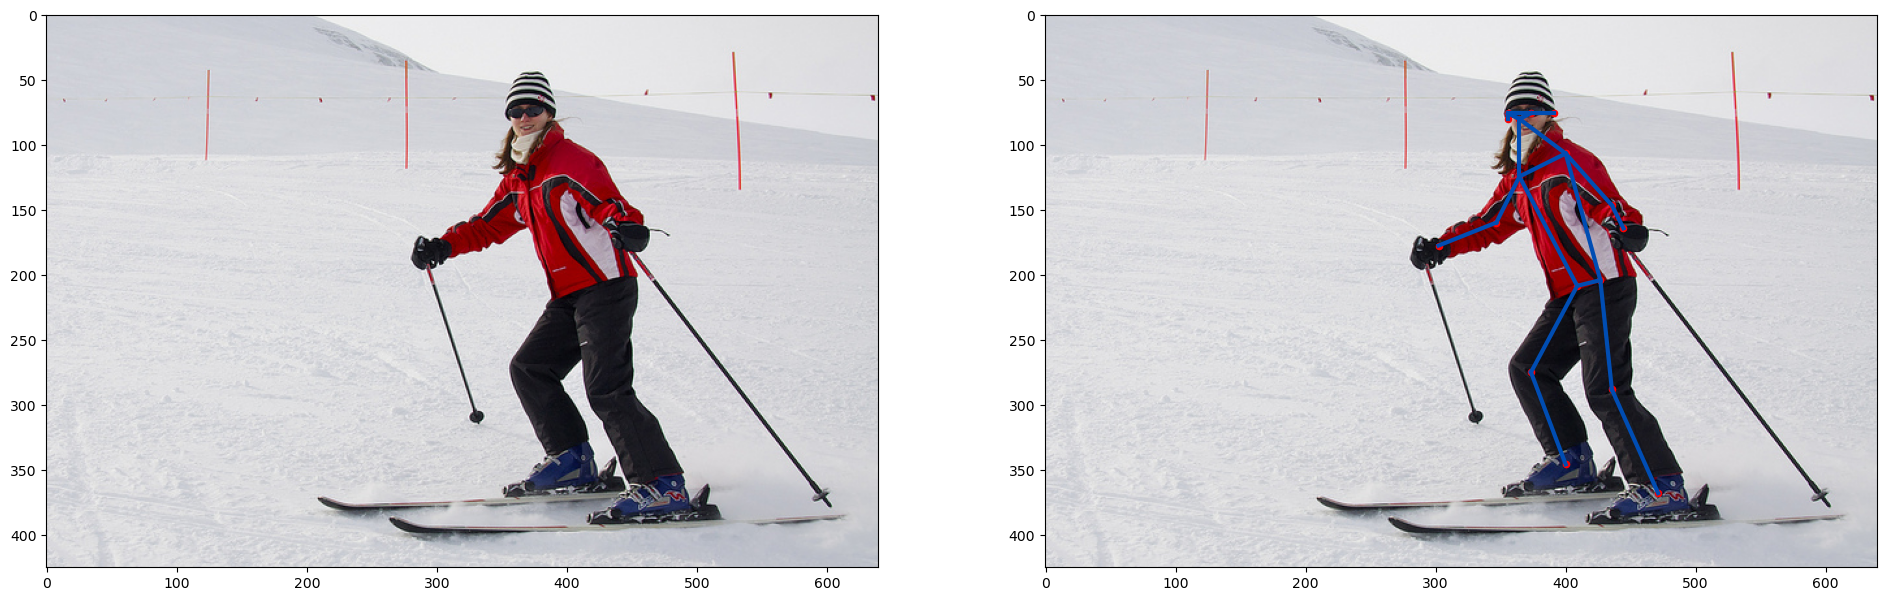

In [2]:
#visualisatie keypoints op image
from misc.visualization import joints_dict
import matplotlib.pyplot as plt
from PIL import Image

def plot_joints(ax, output):
    bones = joints_dict()["coco"]["skeleton"]
    # bones = joints_dict()["mpii"]["skeleton"]

    for bone in bones:
        xS = [output[:,bone[0],1], output[:,bone[1],1]]
        yS = [output[:,bone[0],0], output[:,bone[1],0]]
        ax.plot(xS, yS, linewidth=3, c=(0,0.3,0.7))
    ax.scatter(joints[:,:,1],joints[:,:,0], s=20, c='r')

fig = plt.figure(figsize=(60/2.54, 30/2.54))
ax = fig.add_subplot(121)
ax.imshow(Image.open("demo.jpg"))
ax = fig.add_subplot(122)
ax.imshow(Image.open("demo.jpg"))
plot_joints(ax, joints)
plt.show()

In [3]:
#truth video (van fitness instructeur) inferencen
import cv2
import time
import torch
from misc.visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict, check_video_rotation
from SimpleHRNet import SimpleHRNet
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load HRNet model
model = SimpleHRNet(
    32,  # Example number of channels (adjust as needed)
    17,  # Example number of joints (adjust as needed)
    "./pose_hrnet_w32_256x192.pth",  # Path to pre-trained weights
    device=device,
    multiperson=False
)

# List to store joints for each frame
all_joints_truth = []

# Open the video file
video_path = "push_up.mp4"  # Change this to your video file path
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = float(30)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4 format
video_writer = cv2.VideoWriter('output_push_up.mp4', fourcc, fps, (frame_width, frame_height))

# Check if video is opened successfully
if not video.isOpened():
    print("Error: Could not open video.")
    exit()

# Loop over video frames
while True:
    t = time.time()
    ret, frame = video.read()
    if not ret:
        break  # End of video

    # Make predictions on the current frame
    joints = model.predict(frame) 
    all_joints_truth.append(joints[0]) 

    pts = model.predict(frame)
    person_ids = np.arange(len(pts), dtype=np.int32)

    for i, (pt, pid) in enumerate(zip(pts, person_ids)):
            frame = draw_points_and_skeleton(frame, pt, joints_dict()['coco']['skeleton'], person_index=pid,
                                             points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                             points_palette_samples=10)

    fps = 1. / (time.time() - t)
    print('\rframerate: %f fps, for %d person(s) ' % (fps,len(pts)), end='')
    video_writer.write(frame)
            
# Release video capture and close windows
video_writer.release()

video.release()
cv2.destroyAllWindows()

C:\Users\Gordts-De Laender\Desktop\Papa\OU\DNE\simple-HRNet\SimpleHRNet.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_lo

device: 'cpu'
framerate: 3.373482 fps, for 1 person(s) 

In [4]:
#eigen gemaakte good attempt video inferencen
import cv2
import time
import torch
from misc.visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict, check_video_rotation
from SimpleHRNet import SimpleHRNet
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load HRNet model
model = SimpleHRNet(
    32,  # Example number of channels (adjust as needed)
    17,  # Example number of joints (adjust as needed)
    "./pose_hrnet_w32_256x192.pth",  # Path to pre-trained weights
    device=device,
    multiperson=False
)

# List to store joints for each frame
all_joints_good_attempt = []

# Open the video file
video_path = "good_attempt.mp4"  # Change this to your video file path
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = float(30)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4 format
video_writer = cv2.VideoWriter('output_push_up_good_attempt.mp4', fourcc, fps, (frame_width, frame_height))

# Check if video is opened successfully
if not video.isOpened():
    print("Error: Could not open video.")
    exit()

# Loop over video frames
while True:
    t = time.time()
    ret, frame = video.read()
    if not ret:
        break  # End of video

    # Make predictions on the current frame
    joints = model.predict(frame) 
    all_joints_good_attempt.append(joints[0]) 

    pts = model.predict(frame)
    person_ids = np.arange(len(pts), dtype=np.int32)

    for i, (pt, pid) in enumerate(zip(pts, person_ids)):
            frame = draw_points_and_skeleton(frame, pt, joints_dict()['coco']['skeleton'], person_index=pid,
                                             points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                             points_palette_samples=10)

    fps = 1. / (time.time() - t)
    print('\rframerate: %f fps, for %d person(s) ' % (fps,len(pts)), end='')
    video_writer.write(frame)
            
# Release video capture and close windows
video_writer.release()

video.release()
cv2.destroyAllWindows()


device: 'cpu'
framerate: 2.500391 fps, for 1 person(s) 

In [5]:
#eigen gemaakte bad attempt video inferencen
import cv2
import time
import torch
from misc.visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict, check_video_rotation
from SimpleHRNet import SimpleHRNet
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load HRNet model
model = SimpleHRNet(
    32,  # Example number of channels (adjust as needed)
    17,  # Example number of joints (adjust as needed)
    "./pose_hrnet_w32_256x192.pth",  # Path to pre-trained weights
    device=device,
    multiperson=False
)

# List to store joints for each frame
all_joints_bad_attempt = []

# Open the video file
video_path = "bad_attempt.mp4"  # Change this to your video file path
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = float(30)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4 format
video_writer = cv2.VideoWriter('output_push_up_bad_attempt.mp4', fourcc, fps, (frame_width, frame_height))

# Check if video is opened successfully
if not video.isOpened():
    print("Error: Could not open video.")
    exit()

# Loop over video frames
while True:
    t = time.time()
    ret, frame = video.read()
    if not ret:
        break  # End of video

    # Make predictions on the current frame
    joints = model.predict(frame) 
    all_joints_bad_attempt.append(joints[0]) 

    pts = model.predict(frame)
    person_ids = np.arange(len(pts), dtype=np.int32)

    for i, (pt, pid) in enumerate(zip(pts, person_ids)):
            frame = draw_points_and_skeleton(frame, pt, joints_dict()['coco']['skeleton'], person_index=pid,
                                             points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                             points_palette_samples=10)

    fps = 1. / (time.time() - t)
    print('\rframerate: %f fps, for %d person(s) ' % (fps,len(pts)), end='')
    video_writer.write(frame)
            
# Release video capture and close windows
video_writer.release()

video.release()
cv2.destroyAllWindows()


device: 'cpu'
framerate: 3.326553 fps, for 1 person(s) 

In [6]:
#ander bijna perfect video (van andere fitness istructeur) inferencen
import cv2
import time
import torch
from misc.visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict, check_video_rotation
from SimpleHRNet import SimpleHRNet
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load HRNet model
model = SimpleHRNet(
    32,  # Example number of channels (adjust as needed)
    17,  # Example number of joints (adjust as needed)
    "./pose_hrnet_w32_256x192.pth",  # Path to pre-trained weights
    device=device,
    multiperson=False
)

# List to store joints for each frame
all_joints_bijna_perfect_attempt = []

# Open the video file
video_path = "push_up_almost.mp4"  # Change this to your video file path
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = float(30)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4 format
video_writer = cv2.VideoWriter('output_push_up_push_up_almost.mp4', fourcc, fps, (frame_width, frame_height))

# Check if video is opened successfully
if not video.isOpened():
    print("Error: Could not open video.")
    exit()

# Loop over video frames
while True:
    t = time.time()
    ret, frame = video.read()
    if not ret:
        break  # End of video

    # Make predictions on the current frame
    joints = model.predict(frame) 
    all_joints_bijna_perfect_attempt.append(joints[0]) 

    pts = model.predict(frame)
    person_ids = np.arange(len(pts), dtype=np.int32)

    for i, (pt, pid) in enumerate(zip(pts, person_ids)):
            frame = draw_points_and_skeleton(frame, pt, joints_dict()['coco']['skeleton'], person_index=pid,
                                             points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                             points_palette_samples=10)

    fps = 1. / (time.time() - t)
    print('\rframerate: %f fps, for %d person(s) ' % (fps,len(pts)), end='')
    video_writer.write(frame)
            
# Release video capture and close windows
video_writer.release()

video.release()
cv2.destroyAllWindows()


device: 'cpu'
framerate: 3.080701 fps, for 1 person(s) 

In [7]:
#normaliseren keypoint sequences op basis van torso (zie paper voor uitleg)
import numpy as np

normalized_sequence = []

def normalize_pose_sequence(pose_sequence):
    normalized_sequence = []
    left_shoulder_idx = 5  # Left shoulder index in COCO format
    right_shoulder_idx = 6  # Right shoulder index in COCO format
    
    for frame in pose_sequence:
        # Get the coordinates of the left and right shoulders
        left_shoulder = frame[left_shoulder_idx, :2]  # Only x, y (ignore confidence)
        right_shoulder = frame[right_shoulder_idx, :2]  # Only x, y (ignore confidence)
        
        # Calculate the torso center (midpoint between the shoulders)
        torso_center_x = (left_shoulder[0] + right_shoulder[0]) / 2
        torso_center_y = (left_shoulder[1] + right_shoulder[1]) / 2
        
        # Normalize the joint positions relative to the torso center
        # Flatten the frame into a 1D vector: [joint1_x, joint1_y, joint2_x, joint2_y, ..., jointN_x, jointN_y]
        normalized_frame = []
        for joint in frame:
            normalized_frame.extend([joint[0] - torso_center_x, joint[1] - torso_center_y])  # Only x, y values
            
        normalized_sequence.append(normalized_frame)
    
    return normalized_sequence

truth_sequence_normalized = normalize_pose_sequence(all_joints_truth)
good_attempt_sequence_normalized = normalize_pose_sequence(all_joints_good_attempt)
bad_attempt_sequence_normalized = normalize_pose_sequence(all_joints_bad_attempt)
almost_attempt_sequence_normalized = normalize_pose_sequence(all_joints_bijna_perfect_attempt)

In [8]:
#Dynamic Time Warping (DTW) to get a metric for the similarity between the ground truth video and 
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


# Apply DTW with the Euclidean distance as the cost function on the same videos
distance, path = fastdtw(truth_sequence_normalized, truth_sequence_normalized, dist=euclidean)
# The distance represents how much the keypoints need to be warped to match
print(f"DTW Distance same video: {distance}")

# compare truth and good
distance_truth_good, path_truth_good = fastdtw(truth_sequence_normalized, good_attempt_sequence_normalized, dist=euclidean)
print(f"DTW Distance good attempt: {distance_truth_good}")

# compare bad and good
distance_truth_bad, path_truth_bad  = fastdtw(truth_sequence_normalized, bad_attempt_sequence_normalized, dist=euclidean)
print(f"DTW Distance bad attempt: {distance_truth_bad}")

# compare almost and good
distance_truth_almost, path_truth_almost = fastdtw(truth_sequence_normalized, almost_attempt_sequence_normalized, dist=euclidean)
print(f"DTW Distance almost attempt: {distance_truth_almost}")

DTW Distance same video: 0.0
DTW Distance good attempt: 48366.39678538724
DTW Distance bad attempt: 51394.7802754821
DTW Distance almost attempt: 23352.097450762365


In [9]:
#Code for Resampling with DTW:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d

#function to interpolate sequences to the same length
def resample_sequence(sequence, target_length):
    original_length = len(sequence)
    x = np.linspace(0, 1, original_length)
    interpolator = interp1d(x, sequence, axis=0, kind='linear')
    new_x = np.linspace(0, 1, target_length)
    return interpolator(new_x)

# Resample both sequences to have the same number of frames
target_length = max(len(truth_sequence_normalized), len(good_attempt_sequence_normalized))  # Or set to a fixed number
ground_truth_resampled = resample_sequence(truth_sequence_normalized, target_length)
attempt_resampled = resample_sequence(good_attempt_sequence_normalized, target_length)

# Apply DTW with the Euclidean distance as the cost function - compare truth and good
distance_resampled_1, path_resampled_1  = fastdtw(ground_truth_resampled, attempt_resampled, dist=euclidean)
print(f"DTW Distance GA: {distance_resampled_1}")

# Resample both sequences to have the same number of frames - compare truth and bad
target_length = max(len(truth_sequence_normalized), len(bad_attempt_sequence_normalized))  # Or set to a fixed number
ground_truth_resampled = resample_sequence(truth_sequence_normalized, target_length)
attempt_resampled = resample_sequence(bad_attempt_sequence_normalized, target_length)
distance_resampled_2, path_resampled_2 = fastdtw(ground_truth_resampled, attempt_resampled, dist=euclidean)
print(f"DTW Distance BA: {distance_resampled_2}")

# Resample both sequences to have the same number of frames - compare truth and bad
target_length = max(len(truth_sequence_normalized), len(almost_attempt_sequence_normalized))  # Or set to a fixed number
ground_truth_resampled = resample_sequence(truth_sequence_normalized, target_length)
attempt_resampled = resample_sequence(almost_attempt_sequence_normalized, target_length)
distance_resampled_3, path_resampled_3 = fastdtw(ground_truth_resampled, attempt_resampled, dist=euclidean)
print(f"DTW Distance AA: {distance_resampled_3}")


DTW Distance GA: 49664.26275584977
DTW Distance BA: 50865.35494535042
DTW Distance AA: 25222.95075907095


In [10]:
#Code for Dynamic Speed Scaling with DTW
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Function for resampling a sequence dynamically by interpolating over time
def dynamic_speed_scaling(sequence, target_length):
    """
    Resample a sequence (pose) to the target length to simulate dynamic speed scaling.
    The target_length is typically the length of the other sequence or a fixed desired length.
    
    Parameters:
    sequence (np.array): Original sequence with shape (n_frames, n_keypoints)
    target_length (int): The desired number of frames for resampling the sequence
    
    Returns:
    np.array: Resampled sequence
    """
    original_length = len(sequence)
    x = np.linspace(0, 1, original_length)
    interpolator = interp1d(x, sequence, axis=0, kind='linear')
    new_x = np.linspace(0, 1, target_length)
    return interpolator(new_x)

# Resample Sequence B to match the length of Sequence A (speed scaling) -  compare truth and good
target_length = len(truth_sequence_normalized)  # Matching to ground truth length
B_resampled = dynamic_speed_scaling(good_attempt_sequence_normalized, target_length)


# Apply DTW with Euclidean distance as the cost function 
distance_dynamics_1, path_dynamics_1 = fastdtw(truth_sequence_normalized, B_resampled, dist=euclidean)

# Output the DTW distance (similarity metric)
print(f"DTW Distance with Dynamic Speed Scaling: {distance_dynamics_1}")

# compare truth and bad
target_length = len(truth_sequence_normalized)  # Matching to ground truth length
B_resampled = dynamic_speed_scaling(bad_attempt_sequence_normalized, target_length)


# Apply DTW with Euclidean distance as the cost function
distance_dynamics_2, path_dynamics_2 = fastdtw(truth_sequence_normalized, B_resampled, dist=euclidean)

# Output the DTW distance (similarity metric)
print(f"DTW Distance with Dynamic Speed Scaling: {distance_dynamics_2}")


# compare truth and bad
target_length = len(truth_sequence_normalized)  # Matching to ground truth length
B_resampled = dynamic_speed_scaling(almost_attempt_sequence_normalized, target_length)


# Apply DTW with Euclidean distance as the cost function
distance_dynamics_3, path_dynamics_3 = fastdtw(truth_sequence_normalized, B_resampled, dist=euclidean)

# Output the DTW distance (similarity metric)
print(f"DTW Distance with Dynamic Speed Scaling: {distance_dynamics_3}")

DTW Distance with Dynamic Speed Scaling: 41277.31961577297
DTW Distance with Dynamic Speed Scaling: 50865.35494535042
DTW Distance with Dynamic Speed Scaling: 25222.95075907095


                 Comparison  Distance
0             Truth vs Good  48366.40
1      Truth vs Bad Attempt  51394.78
2   Truth vs Almost perfect  23352.10
3            Resampled Good  49664.26
4             Resampled Bad  50865.35
5  Resampled almost perfect  25222.95
6             Dynamics Good  41277.32
7              Dynamics Bad  50865.35
8   Dynamics almost perfect  25222.95


C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_14912\3597512513.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Comparison', y='Distance', data=df, palette='viridis')


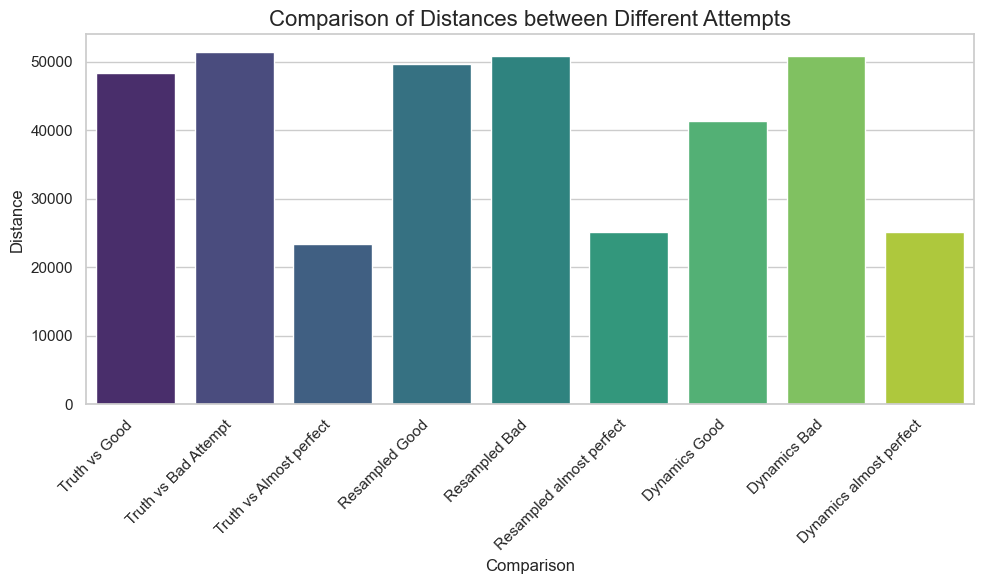

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Comparison': [
        'Truth vs Good', 'Truth vs Bad Attempt', 'Truth vs Almost perfect',
        'Resampled Good', 'Resampled Bad', 'Resampled almost perfect',
        'Dynamics Good', 'Dynamics Bad', 'Dynamics almost perfect'
    ],
    'Distance': [
        distance_truth_good, distance_truth_bad, distance_truth_almost,
        distance_resampled_1, distance_resampled_2, distance_resampled_3,
        distance_dynamics_1, distance_dynamics_2, distance_dynamics_3
    ],
    'Path': [
        str(path_truth_good), str(path_truth_bad), str(path_truth_almost),
        str(path_resampled_1), str(path_resampled_2), str(path_resampled_3),
        str(path_dynamics_1), str(path_dynamics_2), str(path_dynamics_3)
    ]
}
# Create DataFrame
df = pd.DataFrame(data)

# Format the 'Distance' column to 2 decimal places for readability (but keep it as a float)
df['Distance'] = df['Distance'].apply(lambda x: round(x, 2))  # Keep as float

# Display only 'Comparison' and 'Distance' columns
df_visualized = df[['Comparison', 'Distance']]

# Display the table
print(df_visualized)

# Set up the visual properties using seaborn
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Comparison', y='Distance', data=df, palette='viridis')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.title('Comparison of Distances between Different Attempts', fontsize=16)
plt.xlabel('Comparison', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
print(truth_sequence_normalized)
type(truth_sequence_normalized)

[[19.999969482421875, 42.5, 13.33331298828125, 47.5, 6.666656494140625, 47.5, -6.66668701171875, 32.5, -6.66668701171875, 37.5, -6.66668701171875, 2.5, 6.666656494140625, -2.5, 59.999969482421875, -2.5, 66.66665649414062, -2.5, 86.66665649414062, 7.5, 119.99996948242188, 2.5, 6.666656494140625, -97.5, 6.666656494140625, -97.5, 39.999969482421875, -162.5, 39.999969482421875, -157.5, 86.66665649414062, -222.5, 86.66665649414062, -237.5], [19.999969482421875, 42.5, 13.33331298828125, 47.5, 13.33331298828125, 47.5, -6.66668701171875, 32.5, -6.66668701171875, 37.5, -6.66668701171875, 2.5, 6.666656494140625, -2.5, 59.999969482421875, -7.5, 66.66665649414062, -2.5, 86.66665649414062, 7.5, 119.99996948242188, 2.5, 6.666656494140625, -97.5, 6.666656494140625, -97.5, 39.999969482421875, -162.5, 39.999969482421875, -162.5, 86.66665649414062, -222.5, 86.66665649414062, -237.5], [19.999969482421875, 42.5, 13.33331298828125, 47.5, 6.666656494140625, 47.5, -6.66668701171875, 32.5, -6.66668701171875, 

list

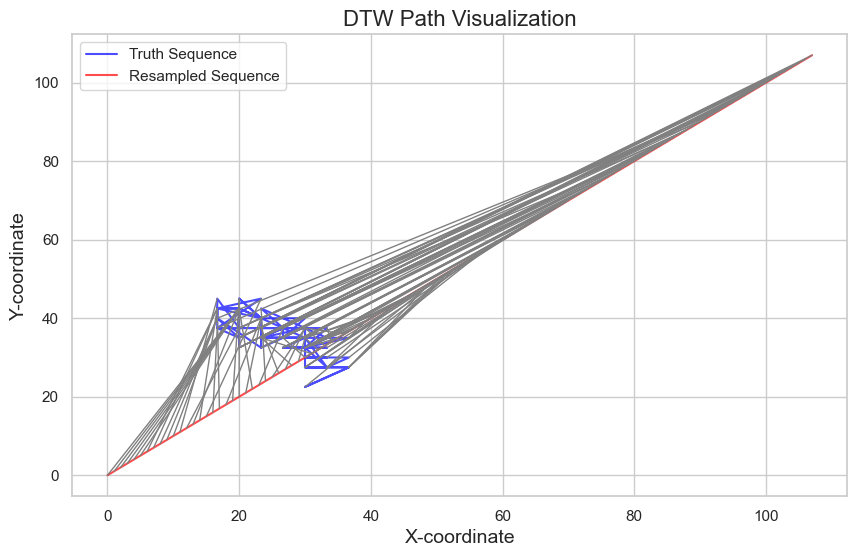

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

truth_sequence_normalized = np.array(truth_sequence_normalized)
B_resampled = np.array(path_dynamics_3)  

# Extract the indices of the alignment path
path_x = [p[0] for p in path_dynamics_3]
path_y = [p[1] for p in path_dynamics_3]

# Plot the sequences and the DTW path
plt.figure(figsize=(10, 6))

# Plot the first sequence
plt.plot(truth_sequence_normalized[:, 0], truth_sequence_normalized[:, 1], label='Truth Sequence', color='blue', alpha=0.7)

# Plot the second sequence
plt.plot(B_resampled[:, 0], B_resampled[:, 1], label='Resampled Sequence', color='red', alpha=0.7)

# Plot the DTW path as a set of connecting lines
for (i, j) in zip(path_x, path_y):
    plt.plot([truth_sequence_normalized[i, 0], B_resampled[j, 0]], 
             [truth_sequence_normalized[i, 1], B_resampled[j, 1]], color='gray', lw=1)

# Add labels and title
plt.title('DTW Path Visualization', fontsize=16)
plt.xlabel('X-coordinate', fontsize=14)
plt.ylabel('Y-coordinate', fontsize=14)
plt.legend(loc='upper left')

# Show the plot
plt.show()
